In [10]:
!pip install qiskit matplotlib pylatexenc networkx scipy

First, let's import the required libraries

In [11]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer
from qiskit.visualization import plot_histogram
from networkx import Graph, draw
from scipy.optimize import minimize

We build the circuit from the graph and a vector that contains the paramters γ and β

In [12]:
def get_circuit(G, theta):
  nqubits = len(G.nodes())
  circuit = QuantumCircuit(nqubits)
  p = len(theta)//2

  gamma = theta[:p]
  beta = theta[p:]

  # Prepare a superposition of states with Hadamard gates
  for i in range(0, nqubits):
    circuit.h(i)

  # Repeat p times the circuits with the problem and mixing Hamiltonians
  for i in range(0,p):
    # Circuit with the problem Hamiltonian
    for l,k in G.edges():
      circuit.rzz(2 * gamma[i],l,k)

    # Circuit with the mixing Hamiltonian
    for qbit in range(0,nqubits):
      circuit.rx(2 * beta[i], qbit)

  # Meeasurement to get one solution
  circuit.measure_all()

  return circuit

Once we have the circuit we prepare the objective function for the classical optimizer. First, let's create a runtime environment (simulated in this case) and let's prepare a function to run the circuit in that environment. This function will be useful to obtain the results once the classic optimization algorithm has optimized the paramters for the circuit.

In [13]:
env = Aer.get_backend('qasm_simulator')

def run_circuit(G, theta, runs=1000):
    circuit = get_circuit(G, theta)
    histogram = env.run(circuit, nshots=runs).result().get_counts()
    return histogram

The objective function must run the quantum circuit several times and compute the average of the objective function for the obtained solutions. We show this function next, where the parameters are the circuit parameters (angles γ and β) and the number of runs of the quantum circuit.

In [14]:
def objective_function(G, runs=1000):

  def count_crossed_edges(solution):
    crossed_edges = 0
    for i,j in G.edges():
      if solution[i] != solution[j]:
        crossed_edges += 1
    return crossed_edges

  def run_average_computation(theta):
    histogram = run_circuit(G, theta, runs)

    sum = 0
    nruns = 0
    for solution, times in histogram.items():
      # The solution is reverted (most significant bit first)
      crossed_edges = count_crossed_edges(solution[::-1])
      sum += crossed_edges * times
      nruns += times

    return -sum/nruns

  return run_average_computation


Now we need a classical optimization algorithm to find the parameters of the quantum circuit. We use SLSQP in SciPy.

In [16]:
def maxim(G):
  objective = objective_function(G)
  return minimize(objective,[1.0,1.0,1.0,1.0], method='COBYLA')


Let's try the algorithm with a graph with 5 vertices and 6 edges.

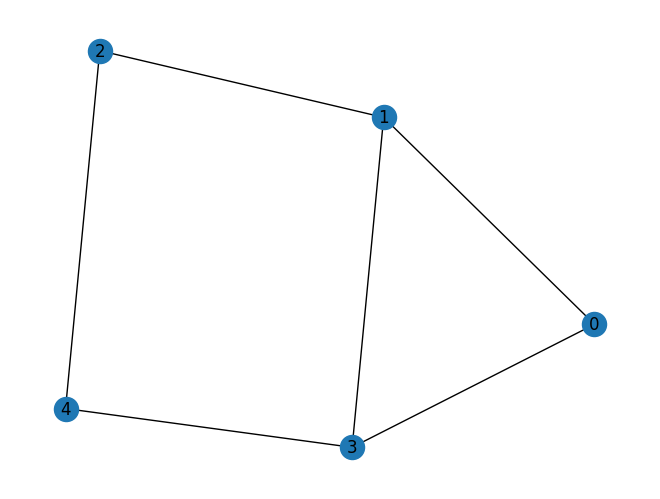

In [17]:
G = Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0,1),(0,3),(1,3),(1,2),(2,4),(3,4)])
draw(G, with_labels=True)

Let's apply QAOA to find the parameters of an "optimal" circuit.

In [18]:
result = maxim(G)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9560546875
       x: [ 1.086e+00  1.725e+00  4.205e-01  1.819e+00]
    nfev: 57
   maxcv: 0.0

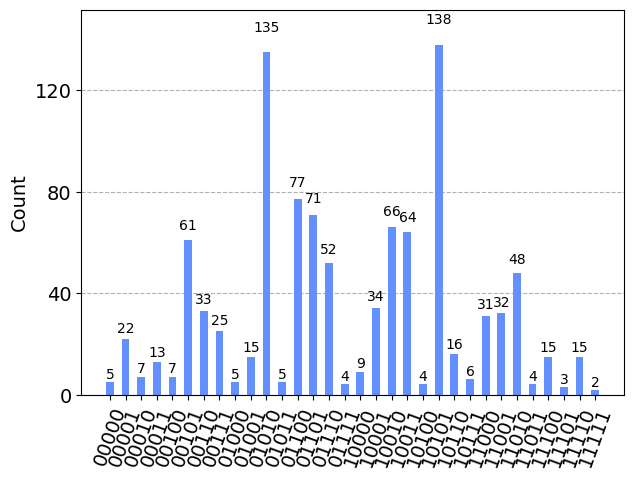

In [20]:
histogram = run_circuit(G, [ 1.086e+00, 1.725e+00, 4.205e-01, 1.819e+00])
plot_histogram(histogram)